In [ ]:
#!pip install aequilibrae
#!pip install OpenMatrix

In [1]:
import sys
from os.path import join
import numpy as np
from math import log10, floor
import matplotlib.pyplot as plt
from aequilibrae.distribution import GravityCalibration, Ipf, GravityApplication, SyntheticGravityModel
from aequilibrae import Parameters
from aequilibrae.project import Project
from aequilibrae.paths import PathResults, SkimResults
from aequilibrae.matrix import AequilibraeData, AequilibraeMatrix
from aequilibrae import logger
from aequilibrae.paths import TrafficAssignment, TrafficClass

import logging



In [2]:

######### FILES AND FOLDER #########

fldr = 'C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment'
proj_name = 'project_database.sqlite'

# remove the comments for the lines below to run the Chicago model example instead
# fldr = 'D:/release/Sample models/Chicago_2020_02_15'

# 9Nodes  SiouxFalls Anaheim

dt_fldr = '0_tntp_data\\9Nodes'
prj_fldr = '1_project\\9Nodes'
skm_fldr = '2_skim_results'
assg_fldr = '4_assignment_results'
dstr_fldr = '5_distribution_results'
frcst_fldr = '6_forecast'
ftr_fldr = '7_future_year_assignment'

In [3]:
########### LOGGING #################

p = Parameters()
p.parameters['system']['logging_directory'] = fldr
p.write_back()
# To make sure the logging will go where it should, stop the script here and
# re-run it

# Because assignment takes a long time, we want the log to be shown here
stdout_handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter("%(asctime)s;%(name)s;%(levelname)s ; %(message)s")
stdout_handler.setFormatter(formatter)
logger.addHandler(stdout_handler)

In [4]:
#---اگر پایتون را در ویندوز اجرا می کنید----

#spatialite  در اینجا پکیج 
# را به پایتون معرفی می کنیم
import os
from aequilibrae.utils.create_example import create_example

os.environ['PATH'] = 'C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment/spatialite-loadable-modules-5.0.0-win-amd64' + ';' + os.environ['PATH']

#----اگر پایتون را در لینوکس اجرا می کنید با دستورات زیر نصب کنید--
#sudo apt-get install libsqlite3-mod-spatialite
#sudo apt-get install -y libspatialite-dev



In [5]:
########### PROJECT #################

project = Project()
project.load(join(fldr, prj_fldr ))


2022-06-08 12:00:48,711;aequilibrae;INFO ; Opened project on C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment\1_project\9Nodes


C:\Users\sd\anaconda3\envs\py38\lib\site-packages\aequilibrae\parameters.py:53: UserWarning: No pre-existing parameter file exists for this project. Will use default
  warn('No pre-existing parameter file exists for this project. Will use default')


C:\Users\sd\AppData\Local\Temp\ipykernel_7396\390546624.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(*geo.xy, 'ro', color='black')


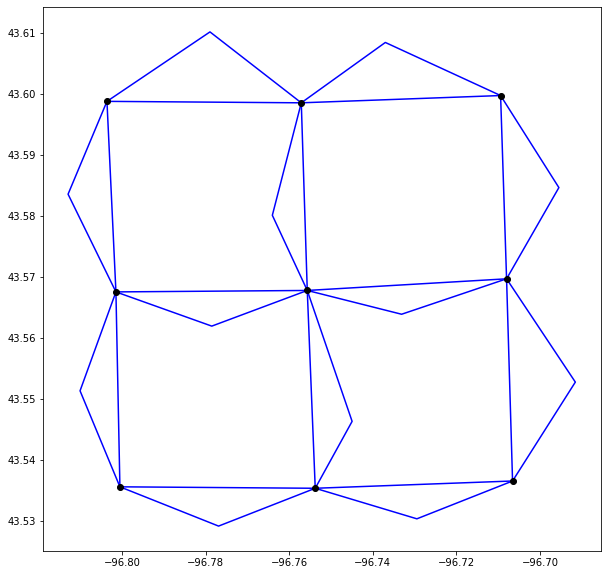

In [6]:
#---رسم شبکه------
curr = project.conn.cursor()
curr.execute("Select link_id from links order by link_id;")
links = project.network.links

plt.figure(figsize=(10,10)) 


for lid in curr.fetchall():
    geo = links.get(lid[0]).geometry

    tmplnk = links.get(lid[0])
    if tmplnk.modes == 'b':
        plt.plot(*geo.xy, color='red')
    else:
        plt.plot(*geo.xy,color='blue')
        
all_nodes = project.network.nodes
curr = project.conn.cursor()
curr.execute('Select node_id from nodes;')

for nid in curr.fetchall():
    geo = all_nodes.get(nid[0]).geometry
    plt.plot(*geo.xy, 'ro', color='black')

#plt.savefig('foo.png', bbox_inches='tight') 

plt.show()

In [7]:
# we build all graphs
project.network.build_graphs()
# We get warnings that several fields in the project are filled with NaNs.  Which is true, but we won't
# use those fields

# we grab the graph for cars
graph = project.network.graphs['c']


2022-06-08 12:00:50,721;aequilibrae;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations
2022-06-08 12:00:50,782;aequilibrae;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations
2022-06-08 12:00:50,839;aequilibrae;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations
2022-06-08 12:00:50,894;aequilibrae;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations


In [23]:
######### TRAFFIC ASSIGNMENT WITH SKIMMING

demand = AequilibraeMatrix()
demand.load(join(fldr, dt_fldr, 'demand.omx'))
demand.computational_view(['matrix'])  # We will only assign one user class stored as 'matrix' inside the OMX file


In [24]:
#!python -c "import sys; print(sys.executable)"

In [25]:
assig = TrafficAssignment()

In [26]:
# Creates the assignment class
assigclass = TrafficClass(graph, demand)


TypeError: __init__() missing 1 required positional argument: 'matrix'

In [18]:
# The first thing to do is to add at list of traffic classes to be assigned
assig.set_classes([assigclass])

assig.set_vdf("BPR")  # This is not case-sensitive # Then we set the volume delay function

assig.set_vdf_parameters({"alpha": "b", "beta": "power"})  # And its parameters

assig.set_capacity_field("capacity")  # The capacity and free flow travel times as they exist in the graph
assig.set_time_field("free_flow_time")


NameError: name 'assigclass' is not defined

In [ ]:
# And the algorithm we want to use to assign
assig.set_algorithm('bfw')

In [ ]:
# since I haven't checked the parameters file, let's make sure convergence criteria is good
assig.max_iter = 1000
assig.rgap_target = 0.00001


In [ ]:
assig.execute()  # we then execute the assignment

In [ ]:
# Convergence report is easy to see
import pandas as pd
convergence_report = pd.DataFrame(assig.assignment.convergence_report)
convergence_report.head()


In [ ]:
volumes = assig.results()
pd.set_option("display.max_rows", None)
volumes


In [ ]:
links.data

In [ ]:
# The link flows are easy to export.
# we do so for csv and AequilibraEData
assigclass.results.save_to_disk(join(fldr, assg_fldr, 'link_flows_c.csv'), output="loads")
assigclass.results.save_to_disk(join(fldr, assg_fldr, 'link_flows_c.aed'), output="loads")


In [ ]:
project.close()


In [ ]:
#نمایش ماتریس تقاضا
demand.get_matrix('matrix').tolist()

#نمایش اطلاعات لینکها
links.data

#--با تغییر مود یک نود آنرا از شبکه کنار میگذاریم

lnk = project.network.links.get(37)
lnk.modes = "c"
lnk.save()